### This Note book is dedicated to compute Graphs and Testing

In [1]:
import os
import numpy as np
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score,confusion_matrix
import scipy
import nibabel as nib

import matplotlib.pyplot as plt

/home/administrator/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [17]:
GT = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/social_nonsocial.npy")
annot = pd.read_csv(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_social_500days1TR.csv")
social1 = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_500days_social.npy")
social2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_500days_social_gaze-speak.npy")
annot1 = annot["social"]
GT = GT[:len(annot1)]
acc = accuracy_score(np.array(annot1),GT)
print("Accuracy:", acc)


GT = GT[:len(social1)]

print(GT.shape, social1.shape)
# acc
acc = accuracy_score(GT, social1)
print("Accuracy:", acc)

#acc2
acc2 = accuracy_score(GT, social2)
print("Accuracy2:", acc2)

Accuracy: 0.8328440366972477
(2150, 1) (2150, 1)
Accuracy: 0.8218604651162791
Accuracy2: 0.7637209302325582


In [9]:
data = pd.read_csv(r"/home/new_storage/sherlock/STS_sherlock/C4/data/annotations_from_model/llava_social_C42TR.csv")
annot = data["social"]
final = data["final"]
annot= np.array(annot)
final = np.array(final)
annot = np.repeat(annot,2)
final = np.repeat(final,2)
annot = annot.reshape(-1, 1)
final = final.reshape(-1, 1)
np.save(r"/home/new_storage/sherlock/STS_sherlock/C4/data/annotations_from_model/llava_social_C42TR.npy", annot)
np.save(r"/home/new_storage/sherlock/STS_sherlock/C4/data/annotations_from_model/llava_social_speak_C42TR.npy", final)

In [10]:
annot.shape 

(1600, 1)

### usefull functions for testing types

In [12]:
## Correlation between annotations

def cosine_between_annotations(annotations1, annotations2):
    """
    Compute the cosine similiarity between two annotations numpy.
    """
    if len(annotations1)>len(annotations2):
        annotations1 = annotations1[:len(annotations2)]
    else:
        annotations2 = annotations2[:len(annotations1)]
    cosine = cosine_similarity(annotations1.reshape(1,-1), annotations2.reshape(1,-1))
    return cosine ,len(annotations1),len(annotations2)

## Plot annotations according to moving average
def plot_annotation(annotations, window_size=10):
    """
    Plot the annotations with a moving average.

    Parameters:
        annotations (numpy array): The annotation values to be smoothed.
        window_size (int): The size of the moving average window.

    Returns:
        numpy array: The smoothed annotations.
    """
    if len(annotations.shape) > 1:  # Ensure it's 1D
        annotations = annotations.flatten()

    # Apply moving average
    window = np.ones(window_size) / window_size
    smoothed_annotations = np.convolve(annotations, window, mode='same')
    smoothed_annotations = np.convolve(annotations.flatten(), window, mode='full')[window_size-1:len(annotations)+window_size-1].reshape(-1, 1)  # Future-only averaging

    # Plot
    plt.figure(figsize=(14, 4))
    plt.scatter(range(len(annotations)), annotations, label="Original Binary Data", color="black", alpha=0.6, s=10)
    plt.plot(smoothed_annotations, label=f"Smoothed (window={window_size})", color="red",alpha=0.5, linewidth=1)
    
    plt.xlabel("TR")
    plt.ylabel("Annotation Value")
    plt.title("Binary Annotations with Moving Average Smoothing")
    ## move the legend

    plt.legend(loc='upper right')
    plt.ylim(-0.1, 1.1)  # Keep within binary range
    plt.show()

    return smoothed_annotations

import os
import numpy as np
import nibabel as nib
def auc(annot1,annot2):
    """
    Compute the AUC between two annotations.
    """
    if len(annot1)>len(annot2):
        annot1 = annot1[:len(annot2)]
    else:
        annot2 = annot2[:len(annot1)]
    auc = roc_auc_score(annot1, annot2)
    return auc

def agg_trials(base_path, regions, model_name, n_trials, n_top_values=100):
    """
    Process multiple brain regions and extract their top voxel values over multiple trials.

    Parameters:
    -----------
    base_path : str
        Base path to the results directory.
    regions : list
        List of brain region names (folder names).
    model_name : str
        Name of the model used in the file naming convention.
    n_trials : int
        Number of trials to process.
    n_top_values : int
        Number of top voxel values to consider per trial.

    Returns:
    --------
    dict : Dictionary with region names as keys and lists of mean top voxel values for each trial.
    """
    # Initialize dictionary to store mean values for each trial
    region_values = {region: [] for region in regions}

    for trial in range(1, n_trials + 1):  # Iterate through all trials
        for region in regions:
            # Construct path for the NIfTI file
            nii_path = os.path.join(base_path, f"llava_sherlock_social_TRrange_{region}", model_name, f"trial_{trial}", "subject4",f"{model_name}_r_sub4.nii")
            
            # Check if the file exists
            if not os.path.exists(nii_path):
                print(f"⚠️ Warning: Missing file {nii_path}")
                region_values[region].append(None)  # Mark as missing for this trial
                continue
            
            # Load and process data
            img = nib.load(nii_path)
            data = img.get_fdata()
            data = data.flatten()

            # Remove NaNs and select top 100 values
            top_values = np.sort(data[~np.isnan(data)])[-n_top_values:]

            # Store mean value for this trial
            region_values[region].append(top_values.mean())

    return region_values

def agg_trials2(base_path, regions, model_name, n_trials, n_top_values=100):
    """
    Process multiple brain regions and extract their top voxel values over multiple trials.

    Parameters:
    -----------
    base_path : str
        Base path to the results directory.
    regions : list
        List of brain region names (folder names).
    model_name : str
        Name of the model used in the file naming convention.
    n_trials : int
        Number of trials to process.
    n_top_values : int
        Number of top voxel values to consider per trial.

    Returns:
    --------
    dict : Dictionary with region names as keys and lists of mean top voxel values for each trial.
    """
    # Initialize dictionary to store mean values for each trial
    region_values = {region: [] for region in regions}

    for trial in range(1, n_trials + 1):  # Iterate through all trials
        for region in regions:
            # Construct path for the NIfTI file
            model_name = f"llava_{trial}TR_onlysocial"
            nii_path = os.path.join(base_path, f"llava_TRrange_onlysocial_{region}_HRF2", "group",model_name, f"trial_{trial}",f"{model_name}_r.nii")
            
            # Check if the file exists
            if not os.path.exists(nii_path):
                print(f"⚠️ Warning: Missing file {nii_path}")
                region_values[region].append(None)  # Mark as missing for this trial
                continue
            
            # Load and process data
            img = nib.load(nii_path)
            data = img.get_fdata()
            data = data.flatten()

            # Remove NaNs and select top 100 values
            top_values = np.sort(data[~np.isnan(data)])[-n_top_values:]

            # Store mean value for this trial
            region_values[region].append(top_values.mean())

    return region_values
def csv_to_annotation(csv_path, output_path,repeat):
    """
    Convert a CSV file to a NIfTI annotation file.

    Parameters:
    -----------
    csv_path : str
        Path to the input CSV file.
    output_path : str
        Path to save the output NIfTI file.
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    data = np.array(df["response"])
    # Repeat the data to match the desired shape
    data = np.repeat(data, repeat)
    data = np.where(data == "Y", 1, 0).astype(np.float32)

    annot2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/social_nonsocial.npy")
    print(annot2.shape)
    anima = annot2[:27].flatten()
    t1 = data[:946]
    t2 = data[946:]
    data = np.concatenate((anima,t1, anima,t2), axis=0)


    data = data.reshape(-1,1)  # Reshape to 2D array (1 row, n columns)
    print(data.shape)
    # Save the NIfTI image
    np.save(output_path, data)

def plot_top_voxels_by_subject(results_base_dir, model, region_list, n_trials, n_subjects, top_k=50):
    import os
    import numpy as np
    import nibabel as nib
    import matplotlib.pyplot as plt

    region_means = {}

    for region in region_list:
        trial_means = []

        for trial in range(1, n_trials + 1):
            subject_means = []

            for subj in range(1, n_subjects + 1):
                subj_path = os.path.join(
                    results_base_dir,
                    f"llava_C4_2TRrange_{region}",
                    model,
                    f"trial_{trial}",
                    f"subject{subj}",
                    f"{model}_r_sub{subj}.nii"
                )

                if not os.path.exists(subj_path):
                    print(f"⚠️ Missing subject file: {subj_path}")
                    continue

                subj_r = nib.load(subj_path).get_fdata().flatten()
                if np.isnan(subj_r).all():
                    print(f"⚠️ All NaNs in subject {subj} trial {trial} region {region}")
                    continue

                valid_voxels = ~np.isnan(subj_r)
                sorted_indices = np.argsort(subj_r[valid_voxels])

                if top_k == "all":
                    top_voxel_indices = np.where(valid_voxels)[0]
                else:
                    top_voxel_indices = np.where(valid_voxels)[0][sorted_indices[-top_k:]]

                top_voxel_values = subj_r[top_voxel_indices]
                subject_mean = np.nanmean(top_voxel_values)
                subject_means.append(subject_mean)

            trial_mean = np.mean(subject_means) if subject_means else np.nan
            trial_means.append(trial_mean)

        region_means[region] = trial_means

    # Plotting
    trials = np.arange(1, n_trials + 1)
    
    plt.figure(figsize=(10, 6))
    for region in region_list:
        m = np.array(region_means[region])
        plt.plot(trials, m, label=region, marker='o', linestyle='-')

    plt.xlabel("Trial")
    plt.ylabel("Mean of Subject-Level Top-K r-values")
    
    plt.title(f"{model}: Avg Subject Top-{top_k} Voxel r-values (per region)")
    plt.grid(True)
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()


In [13]:
data = pd.read_csv(r"/home/new_storage/sherlock/STS_sherlock/C4/data/annotations_from_model/llava_social_C41TR.csv")
final = data["final"]
annot = np.array(final)
annot = annot.reshape(-1, 1)  # Ensure it's a 2D array for NIfTI saving
np.save(r"/home/new_storage/sherlock/STS_sherlock/C4/data/annotations_from_model/llava_social_speak_C41TR.npy", annot)

⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject1/500_social_r_sub1.nii
⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject2/500_social_r_sub2.nii
⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject3/500_social_r_sub3.nii
⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject4/500_social_r_sub4.nii
⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject5/500_social_r_sub5.nii
⚠️ Missing subject file: /home/new_storage/sherlock/STS_sherlock/500days/data/results/llava_TRrange_onlysocial_STS/500_social/trial_1/subject6/500_social_r_sub6.nii
⚠️ Missing

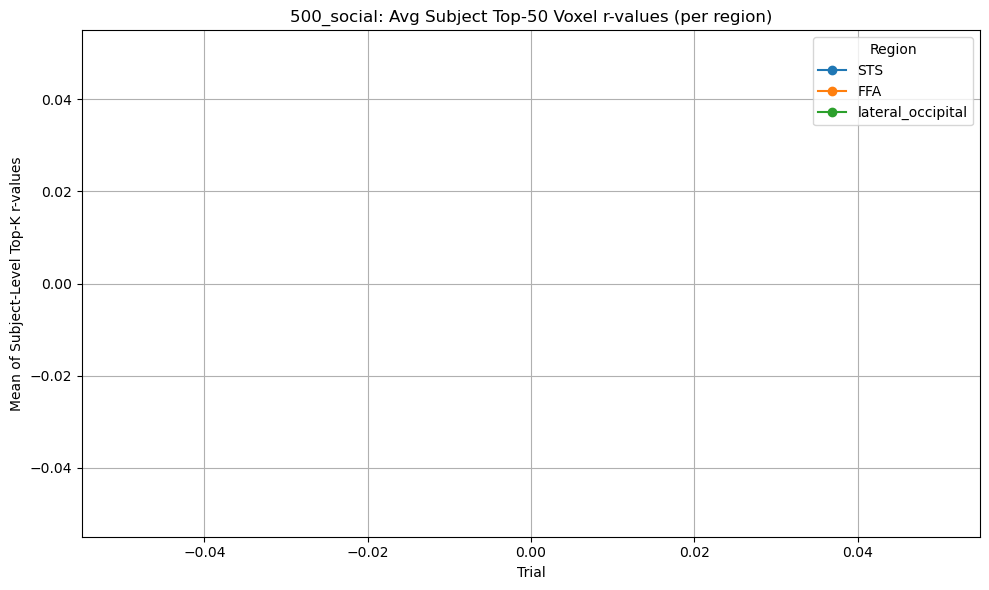

In [12]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/500days/data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="500_social",
    region_list=["STS", "FFA","lateral_occipital"],
    n_trials=20,
    n_subjects=10,
    top_k=50
)


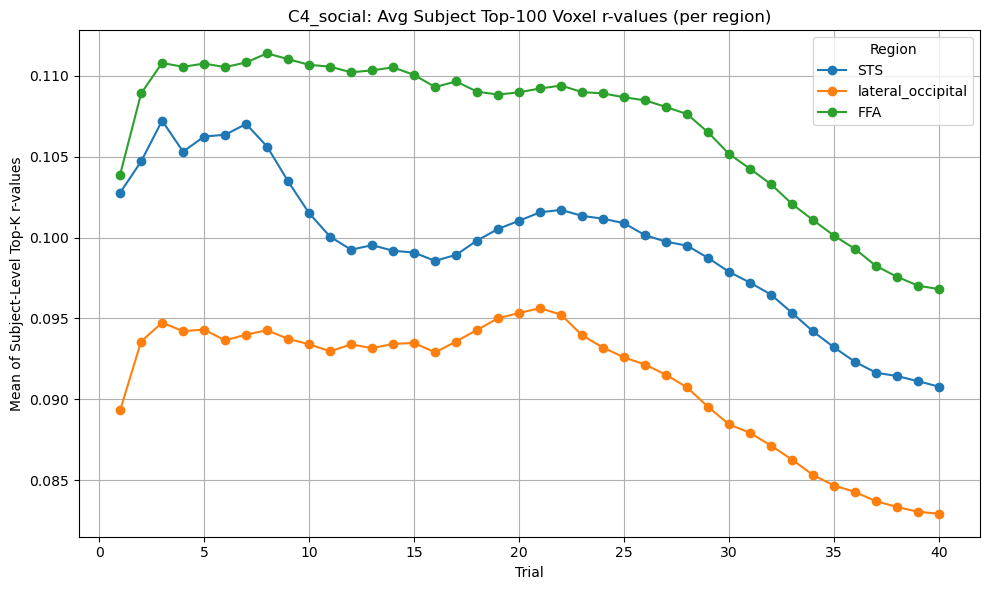

In [ ]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/C4/data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="C4_social",
    region_list=["STS", "lateral_occipital","FFA"],
    n_trials=40,
    n_subjects=18,
    top_k=100
)


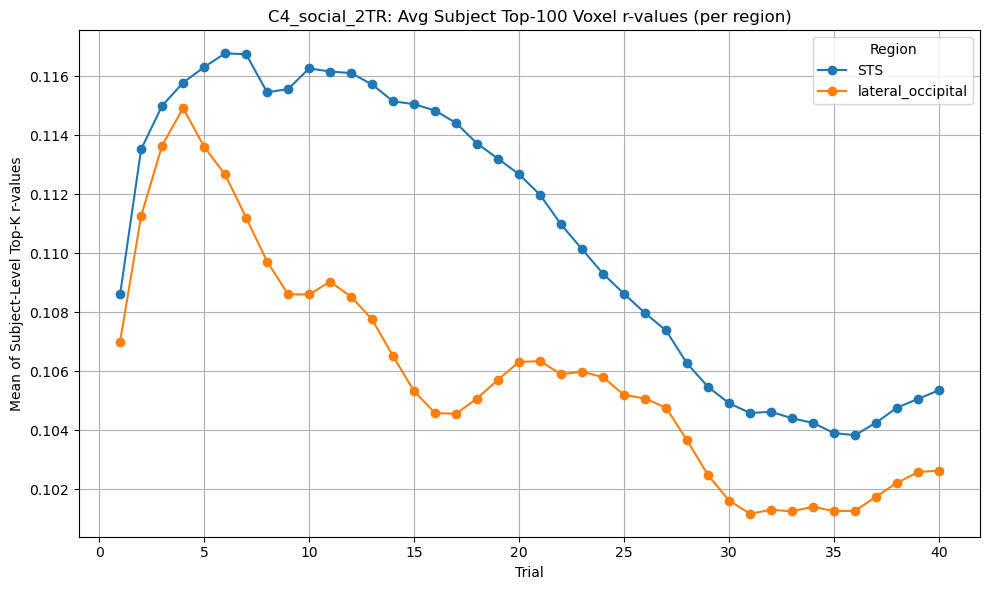

In [ ]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/C4/data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="C4_social_2TR",
    region_list=["STS", "lateral_occipital","FFA"],
    n_trials=40,
    n_subjects=18,
    top_k=100
)


In [ ]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/C4/data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="C4_social_2TR",
    region_list=["STS2"],
    n_trials=40,
    n_subjects=18,
    top_k=100
)


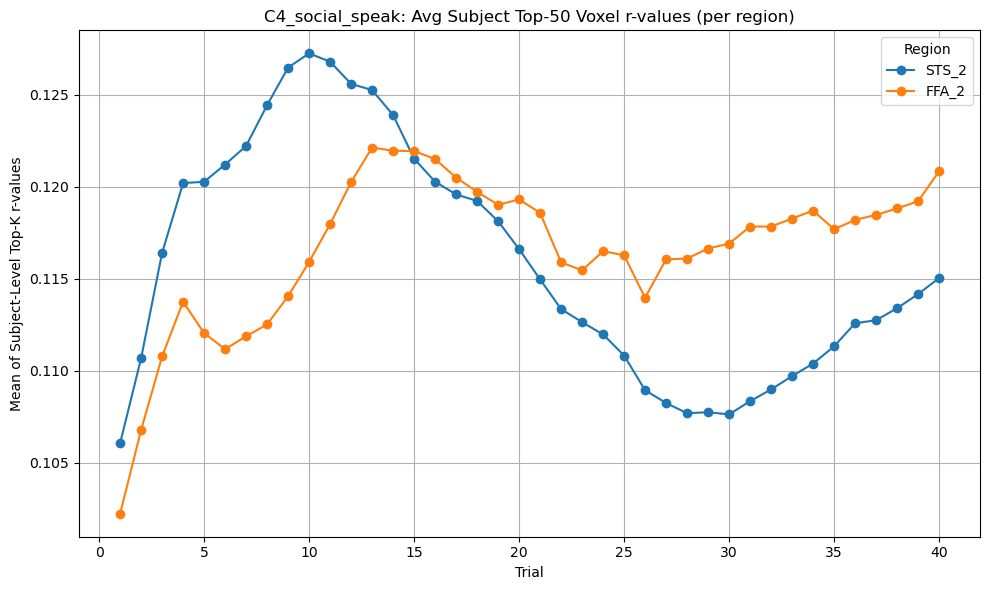

In [15]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/C4/data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="C4_social_speak",
    region_list=["STS_2", "FFA_2"],
    n_trials=40,
    n_subjects=1,
    top_k=50
)


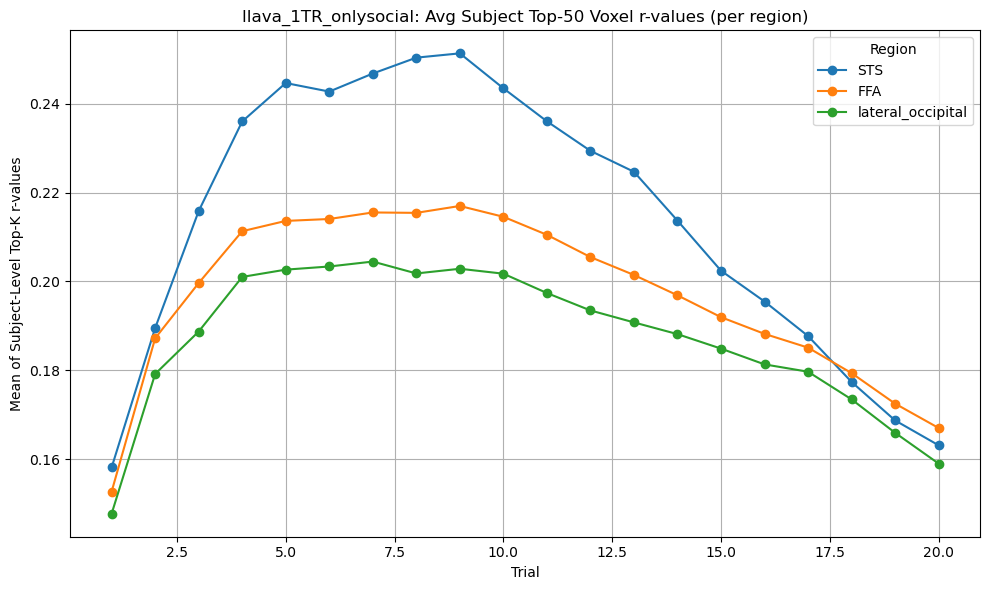

In [16]:
results_base_dir="/home/new_storage/sherlock/STS_sherlock/projects data/results"
plot_top_voxels_by_subject(
    results_base_dir=results_base_dir,
    model="llava_1TR_onlysocial",
    region_list=["STS", "FFA","lateral_occipital"],
    n_trials=20,
    n_subjects=17,
    top_k=50
)


dict_values([[0.2857053613538405, 0.3389682274151619, 0.34701223400338477, 0.34777698806729407, 0.3405548559449123, 0.34618539114488006, 0.34259862574331573, 0.3341195259175391, 0.32811402035983883, 0.31939416038200813, 0.31362566243563916, 0.29740204589081737, 0.28233213602357665, 0.2730523840797464, 0.2621315324336947, 0.25284227953600596, 0.24314100630724256, 0.23917210306492642, 0.2319541970838153, 0.22388810095509928, 0.21498855222708166, 0.2046344036059323, 0.1995979572612032, 0.1980517242873951, 0.19029501795391193, 0.18154843665818188, 0.17664487852859312, 0.16814996096536128, 0.16095659861220793, 0.15753311975577136, 0.15222007152136263, 0.14857283202367497, 0.14755432182531117, 0.14918883909105266, 0.1475709223205735, 0.14658158165496693, 0.1465413512177721, 0.14564096818927175, 0.1431847935712093, 0.14210567883664635, 0.14009194947898615, 0.13837289826883553, 0.13734965659772042, 0.1357883968378695, 0.13522958377218675, 0.13493366427682263, 0.13473001685319916, 0.13527379598

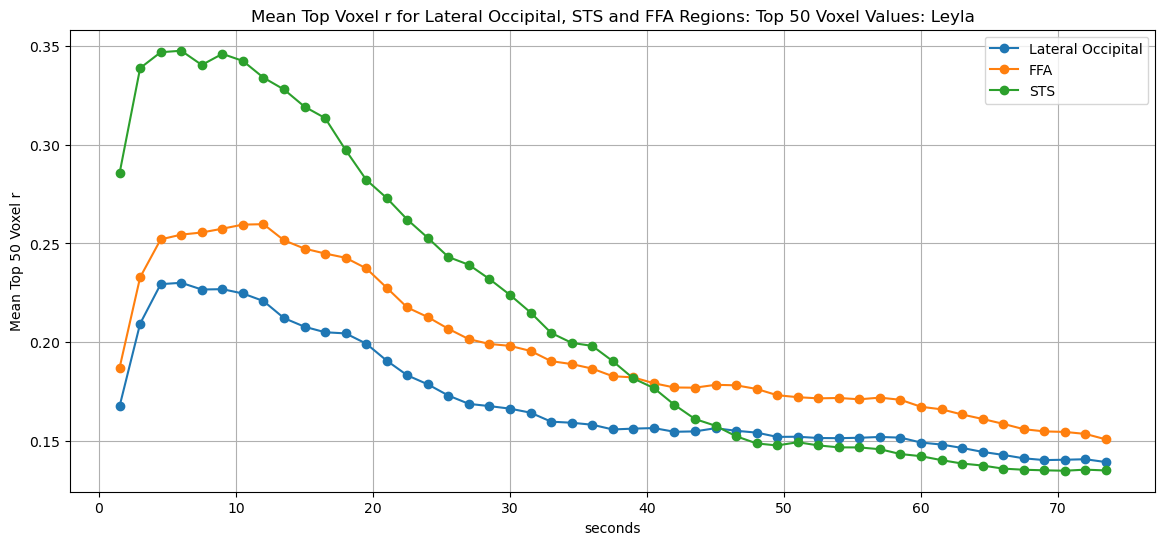

In [48]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]


# Process all regionsllava_500days_TRrange_FFA
n=50
results = agg_trials(base_path, regions, n_trials=49, n_top_values=n, model_name="llava_1TR_onlysocial")

# Access values for each region

print(results.values())
sts_values = results['STS']
ffa_values = results['FFA']
lateral_occipital_values = results['lateral_occipital']
# Plot the results
trials = range(1, 50)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




In [38]:
import numpy as np
data = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/lava_face_1000.npy")

annot2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/face.npy")
#annot2[annot2 == -1]=0
#annot2 =annot2.flatten()
#anima = annot2[:27]
#annotation = np.concatenate((anima,data), axis=0)
#t1 = annotation[:946]
#t2 = annotation[946:]

#annotation = np.concatenate([t1,anima,t2])
#data = annotation[:1976]
annot2 = annot2[:len(data)]
print(data.shape, annot2.shape)
#np.save(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/indoor_outdoor_llava.npy", data)
print("GT counts:", np.bincount(annot2.astype(int)))
print("Prediction counts:", np.bincount(data.astype(int)))


print("Predicted 1s:", np.sum(data))
print("GT 1s:", np.sum(annot2))
print(accuracy_score(data.flatten(), annot2.flatten()))
print(confusion_matrix(data.flatten(), annot2.flatten()))
#print(cosine_between_annotations(data.flatten(), annot2.flatten()))
print(pearsonr(data.flatten(), annot2.flatten()))

(1054, 1) (1054, 1)


ValueError: object too deep for desired array

In [8]:
import numpy as np
data = pd.read_csv(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_social_500days1TR.csv")
data = np.array(data["final"])
data = pd.Series(data)
print(np.sum(data), data.shape)
print(data.value_counts())
## Reshape the data to 2D array (1 row, n columns)
data = np.array(data)
data = data.reshape(-1, 1)  # Reshape to 2D array (1 row, n columns)
print(data.shape)

np.save(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_500days_social_gaze-speak.npy", data)


1856 (2150,)
1    1856
0     294
dtype: int64
(2150, 1)


In [13]:
data1 = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_500days_social_gaze-speak.npy")
data2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/llava_500days_social.npy")
GT = np.load(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/social_nonsocial.npy")
print(pd.array(GT.flatten()).value_counts())
GT[GT == 0.5] = 1

data1 = data1.flatten()
data2 = data2.flatten()

GT = GT.flatten()
GT = GT[:len(data1)]  # Ensure GT matches the length of data1 and data2
print(accuracy_score(data1, GT), accuracy_score(data2, GT))
print(data1.shape, data2.shape)

0    1758
1    3711
dtype: Int64
0.7637209302325582 0.8218604651162791
(2150,) (2150,)


In [4]:
## load .mat and conver to numpy
import scipy.io
import numpy
mat = scipy.io.loadmat(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/face.mat")
mat = numpy.array(mat["face"])
print(mat.shape)
np.save(r"/home/new_storage/sherlock/STS_sherlock/500days/data/annotations_from_models/face.npy", mat)

(1722, 1)


In [26]:
data = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_13.5s_video.npy")

annot2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/social_nonsocial.npy")
data[data == -1]=0
annot2[annot2 == -1]=0
annot2 = annot2[:len(data)]
print(accuracy_score(data.flatten(), annot2.flatten()))
print(confusion_matrix(data.flatten(), annot2.flatten()))
print(cosine_between_annotations(data.flatten(), annot2.flatten()))
print(pearsonr(data.flatten(), annot2.flatten()))
print(np.sum(annot2==1)/len(annot2))
print(np.where(data.flatten() - annot2.flatten() ==-1)[0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_13.5s_video.npy'

In [53]:
import matplotlib.pyplot as plt
acc = []
for i in range (1,14):
    orig = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/social_nonsocial.npy")
    path = f"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_pics_social_non_social(TR{i}).npy"
    print(i)
    data = np.load(path)
    data[data == -1]=0
    orig[orig == -1]=0
    orig = orig.flatten()
    data = data.flatten()
    orig = orig[:data.shape[0]]
    print(data.shape, orig.shape)
    acc.append(accuracy_score(data, orig))

1
(1976,) (1976,)
2
(1976,) (1976,)
3
(1976,) (1976,)
4
(1976,) (1976,)
5
(1976,) (1976,)
6
(1976,) (1976,)
7
(1804,) (1804,)
8
(1976,) (1976,)
9
(1976,) (1976,)
10
(1976,) (1976,)
11
(1976,) (1976,)
12
(1976,) (1976,)
13
(1976,) (1976,)


Text(0.5, 1.0, 'Accuracy of LLAVA - pics Annotations vs Social Non-Social Annotations')

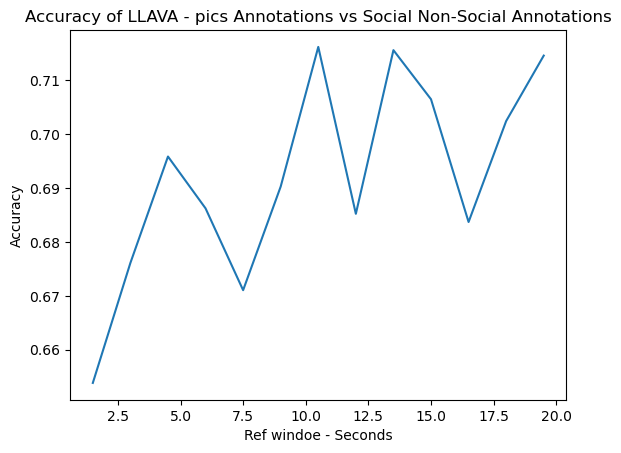

In [54]:
plt.plot(np.arange(1*1.5,14*1.5,1.5), acc)
plt.xlabel("Ref windoe - Seconds")
plt.ylabel("Accuracy")
plt.title("Accuracy of LLAVA - pics Annotations vs Social Non-Social Annotations")

Text(0.5, 1.0, 'Accuracy of LLAVA - vid Annotations vs Social Non-Social Annotations')

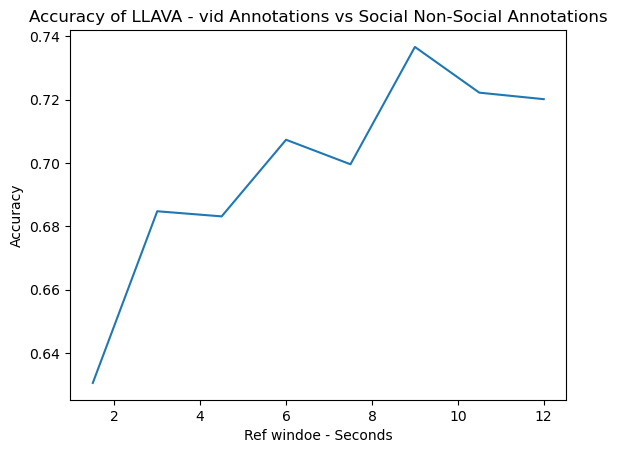

In [52]:
plt.plot(np.arange(1.5,13.5,1.5), acc)
plt.xlabel("Ref windoe - Seconds")
plt.ylabel("Accuracy")
plt.title("Accuracy of LLAVA - vid Annotations vs Social Non-Social Annotations")

In [50]:
import matplotlib.pyplot as plt
acc = []
for i in np.arange(1.5,13.5,1.5):
    orig = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/social_nonsocial.npy")
    path = f"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_{i}s_video.npy"
    print(i)
    data = np.load(path)
    data[data == -1]=0
    orig[orig == -1]=0
    orig = orig.flatten()
    data = data.flatten()
    orig = orig[:data.shape[0]]
    print(data.shape, orig.shape)
    acc.append(accuracy_score(data, orig))

1.5
(1954,) (1954,)
3.0
(1954,) (1954,)
4.5
(1944,) (1944,)
6.0
(1934,) (1934,)
7.5
(1954,) (1954,)
9.0
(1914,) (1914,)
10.5
(1944,) (1944,)
12.0
(1894,) (1894,)


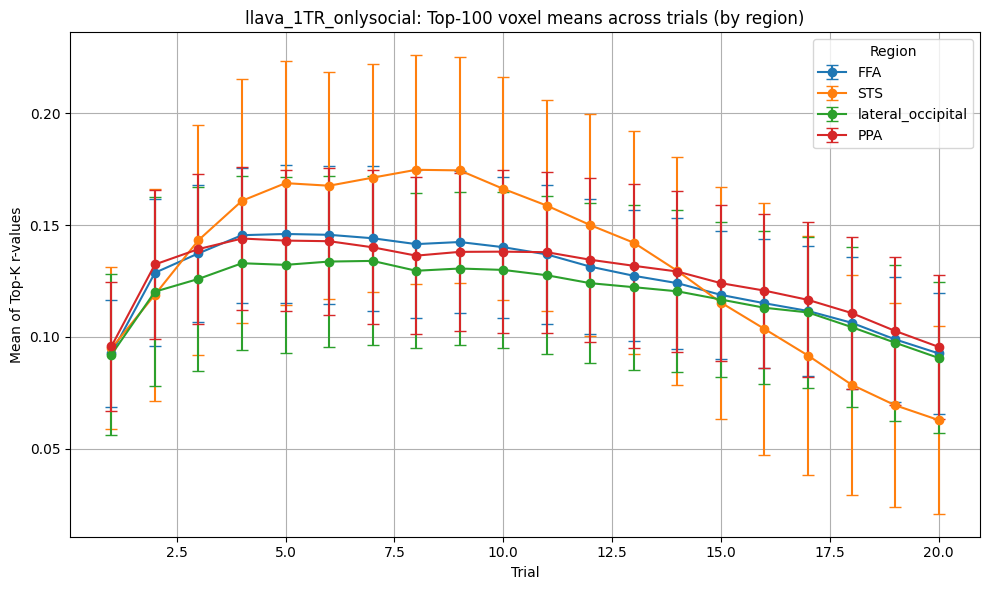

In [77]:
plot_multiple_regions_with_std(
    results_base_dir="/home/new_storage/sherlock/STS_sherlock/projects data/results",
    model="llava_1TR_onlysocial",
    region_list=["FFA", "STS", "lateral_occipital","PPA"],
    n_trials=20,
    n_subjects=17,
    top_k=100
)

In [10]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import ttest_rel

# Parameters
results_dir = "/home/new_storage/sherlock/STS_sherlock/projects data/results"
model_name = "llava_1TR_onlysocial"
regions = ["STS", "PPA"]
n_subjects = 17
trials_to_test = [1,2,3,4,5,6,7,8,9, 10, 20]
top_k = 100

records = []

for region in regions:
    region_dir = os.path.join(results_dir, f"llava_TRrange_onlysocial_{region}")
    
    for trial in trials_to_test:
        trial_path = os.path.join(region_dir, model_name, f"trial_{trial}")
        group_r_path = os.path.join(trial_path, "group", f"{model_name}_r.nii")
        if not os.path.exists(group_r_path):
            continue

        group_r = nib.load(group_r_path).get_fdata().flatten()
        valid_voxels = ~np.isnan(group_r)
        top_voxel_indices = np.argsort(group_r[valid_voxels])[-top_k:]
        full_indices = np.where(valid_voxels)[0][top_voxel_indices]

        for subj in range(1, n_subjects + 1):
            subj_path = os.path.join(trial_path, f"subject{subj}", f"{model_name}_r_sub{subj}.nii")
            if not os.path.exists(subj_path):
                continue
            subj_r = nib.load(subj_path).get_fdata().flatten()
            subj_mean = np.nanmean(subj_r[full_indices])
            records.append({
                "Subject": subj,
                "Region": region,
                "Trial": trial,
                "R_value": subj_mean
            })

df = pd.DataFrame(records)

# Pivot and compute stats
df_pivot = df.pivot_table(index=["Subject", "Region"], columns="Trial", values="R_value").reset_index()

# Paired t-tests
growth_sts = ttest_rel(df_pivot[df_pivot.Region == "STS"][1], df_pivot[df_pivot.Region == "STS"][9])
growth_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][1], df_pivot[df_pivot.Region == "FFA"][9])
decline_sts = ttest_rel(df_pivot[df_pivot.Region == "STS"][9], df_pivot[df_pivot.Region == "STS"][20])
decline_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][9], df_pivot[df_pivot.Region == "FFA"][20])

delta_sts = df_pivot[df_pivot.Region == "STS"][9] - df_pivot[df_pivot.Region == "STS"][20]
delta_ffa = df_pivot[df_pivot.Region == "FFA"][9] - df_pivot[df_pivot.Region == "FFA"][20]
decline_diff = ttest_rel(delta_sts, delta_ffa)
delta_growth_sts = df_pivot[df_pivot.Region == "STS"][9] - df_pivot[df_pivot.Region == "STS"][1]
delta_growth_ffa = df_pivot[df_pivot.Region == "FFA"][9] - df_pivot[df_pivot.Region == "FFA"][1]

growth_diff = ttest_rel(delta_growth_sts, delta_growth_ffa)

print("\n📈 STS: Trial 1 → 10 (growth):", growth_sts)
print("📈 FFA: Trial 1 → 10 (growth):", growth_ffa)
print("📉 STS: Trial 10 → 20 (decline):", decline_sts)
print("📉 FFA: Trial 10 → 20 (decline):", decline_ffa)
print("📊 Difference in decline (STS vs FFA):", decline_diff)
print("📊 Difference in growth (STS vs FFA):", growth_diff)


/tmp/ipykernel_2415329/2514489766.py:51: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  growth_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][1], df_pivot[df_pivot.Region == "FFA"][9])
/tmp/ipykernel_2415329/2514489766.py:53: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  decline_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][9], df_pivot[df_pivot.Region == "FFA"][20])


ValueError: Array shapes are incompatible for broadcasting.

In [11]:
df_pivot1 = df_pivot.copy()
df_pivot1["model"] = 1

In [5]:
df_pivot1

Trial,Subject,Region,1,2,3,4,5,6,7,8,9,10,20,model
0,1,FFA,0.097666,0.117151,0.129231,0.148921,0.154739,0.156531,0.158929,0.160550,0.165779,0.159845,0.074149,1
1,1,STS,0.081702,0.126495,0.159749,0.174608,0.181168,0.180159,0.181337,0.179844,0.176257,0.178110,0.095857,1
2,2,FFA,0.105693,0.147000,0.142406,0.151172,0.149805,0.150936,0.146553,0.141577,0.138637,0.137591,0.083339,1
3,2,STS,0.082168,0.101990,0.130490,0.147012,0.162054,0.165820,0.170135,0.177108,0.183832,0.167690,-0.004868,1
4,3,FFA,0.102742,0.136709,0.145301,0.162569,0.156099,0.149327,0.143857,0.141010,0.140564,0.138917,0.112287,1
5,3,STS,0.153561,0.162933,0.182531,0.197976,0.201058,0.194599,0.197634,0.200832,0.197033,0.185056,0.056699,1
6,4,FFA,0.095623,0.119791,0.129797,0.127796,0.125568,0.126184,0.125007,0.118911,0.125375,0.129196,0.083544,1
7,4,STS,0.147783,0.193854,0.228752,0.250457,0.259812,0.256440,0.263912,0.267326,0.266499,0.260958,0.132928,1
8,5,FFA,0.091705,0.130010,0.140139,0.120406,0.105256,0.106497,0.105889,0.103566,0.106807,0.107898,0.052745,1
9,5,STS,0.060791,0.091695,0.101069,0.118780,0.134047,0.134552,0.136917,0.137559,0.141147,0.133929,0.011045,1


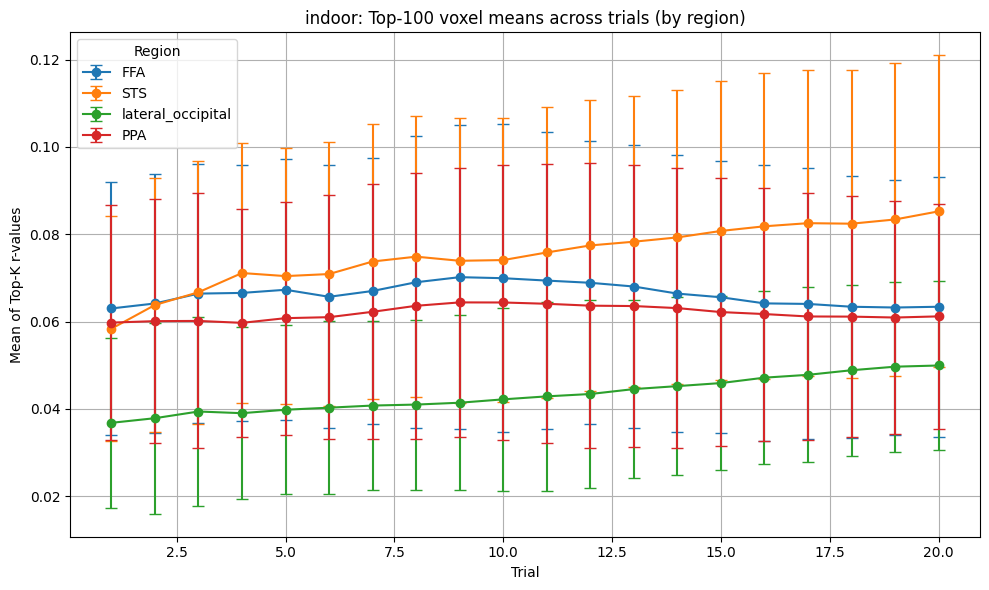

In [140]:
plot_multiple_regions_with_std(
    results_base_dir="/home/new_storage/sherlock/STS_sherlock/projects data/results",
    model="indoor",
    region_list=["FFA", "STS", "lateral_occipital","PPA"],
    n_trials=20,
    n_subjects=17,
    top_k=100
)

In [12]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import ttest_rel

# Parameters
results_dir = "/home/new_storage/sherlock/STS_sherlock/projects data/results"
model_name = "indoor"
regions = ["STS", "PPA"]
n_subjects = 17
trials_to_test = [1,2,3,4,5,6,7,8,9, 10, 20]
top_k = 100

records = []

for region in regions:
    region_dir = os.path.join(results_dir, f"llava_TRrange_indoor_{region}")
    
    for trial in trials_to_test:
        trial_path = os.path.join(region_dir, model_name, f"trial_{trial}")
        group_r_path = os.path.join(trial_path, "group", f"{model_name}_r.nii")
        if not os.path.exists(group_r_path):
            continue

        group_r = nib.load(group_r_path).get_fdata().flatten()
        valid_voxels = ~np.isnan(group_r)
        top_voxel_indices = np.argsort(group_r[valid_voxels])[-top_k:]
        full_indices = np.where(valid_voxels)[0][top_voxel_indices]

        for subj in range(1, n_subjects + 1):
            subj_path = os.path.join(trial_path, f"subject{subj}", f"{model_name}_r_sub{subj}.nii")
            if not os.path.exists(subj_path):
                continue
            subj_r = nib.load(subj_path).get_fdata().flatten()
            subj_mean = np.nanmean(subj_r[full_indices])
            records.append({
                "Subject": subj,
                "Region": region,
                "Trial": trial,
                "R_value": subj_mean
            })

df = pd.DataFrame(records)

# Pivot and compute stats
df_pivot2 = df.pivot_table(index=["Subject", "Region"], columns="Trial", values="R_value").reset_index()
df_pivot2["model"] = -1
# Paired t-tests
growth_sts = ttest_rel(df_pivot[df_pivot.Region == "STS"][1], df_pivot[df_pivot.Region == "STS"][9])
growth_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][1], df_pivot[df_pivot.Region == "FFA"][9])
decline_sts = ttest_rel(df_pivot[df_pivot.Region == "STS"][9], df_pivot[df_pivot.Region == "STS"][20])
decline_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][9], df_pivot[df_pivot.Region == "FFA"][20])

delta_sts = df_pivot[df_pivot.Region == "STS"][9] - df_pivot[df_pivot.Region == "STS"][20]
delta_ffa = df_pivot[df_pivot.Region == "FFA"][9] - df_pivot[df_pivot.Region == "FFA"][20]
decline_diff = ttest_rel(delta_sts, delta_ffa)
delta_growth_sts = df_pivot[df_pivot.Region == "STS"][9] - df_pivot[df_pivot.Region == "STS"][1]
delta_growth_ffa = df_pivot[df_pivot.Region == "FFA"][9] - df_pivot[df_pivot.Region == "FFA"][1]

growth_diff = ttest_rel(delta_growth_sts, delta_growth_ffa)

print("\n📈 STS: Trial 1 → 10 (growth):", growth_sts)
print("📈 FFA: Trial 1 → 10 (growth):", growth_ffa)
print("📉 STS: Trial 10 → 20 (decline):", decline_sts)
print("📉 FFA: Trial 10 → 20 (decline):", decline_ffa)
print("📊 Difference in decline (STS vs FFA):", decline_diff)
print("📊 Difference in growth (STS vs FFA):", growth_diff)


/tmp/ipykernel_2415329/1163220480.py:51: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  growth_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][1], df_pivot[df_pivot.Region == "FFA"][9])
/tmp/ipykernel_2415329/1163220480.py:53: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  decline_ffa = ttest_rel(df_pivot[df_pivot.Region == "FFA"][9], df_pivot[df_pivot.Region == "FFA"][20])


ValueError: Array shapes are incompatible for broadcasting.

In [13]:
df_pivot = pd.concat([df_pivot1, df_pivot2], axis=0)

In [14]:
# Convert trial columns to string if they are not already
df_pivot.columns = [str(col) if isinstance(col, int) else col for col in df_pivot.columns]

# Melt the DataFrame to long format for trials 1 and 9
df_pivot = df_pivot.melt(id_vars=["Subject", "Region", "model"], value_vars=["1" ,"2","3","4","5","6","7","8","9"], 
                         var_name="Trial", value_name="R_value")


In [15]:

df_pivot["Region"][df_pivot["Region"]=="STS"] =1
df_pivot["Region"][df_pivot["Region"]=="PPA"] =-1

/tmp/ipykernel_2415329/1379817251.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pivot["Region"][df_pivot["Region"]=="STS"] =1
/tmp/ipykernel_2415329/1379817251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [16]:
df_pivot = df_pivot.rename(columns={"model": "ModelType"})

In [21]:
df_pivot

,Subject,Region,ModelType,Trial,R_value
0,1,-1,1,-4.0,0.100236
1,1,1,1,-4.0,0.081702
2,2,-1,1,-4.0,0.119497
3,2,1,1,-4.0,0.082168
4,3,-1,1,-4.0,0.087283
...,...,...,...,...,...
607,15,1,-1,4.0,0.099392
608,16,-1,-1,4.0,0.063457
609,16,1,-1,4.0,0.050674
610,17,-1,-1,4.0,0.085506


In [20]:
## Center the trials
df_pivot["Trial"] = df_pivot["Trial"].astype(int)  # Ensure Trial is integer for mean calculation
df_pivot["Trial"] = df_pivot["Trial"] - df_pivot["Trial"].mean() 

In [22]:
import statsmodels.formula.api as smf

# Convert to categorical if they're not already
df_pivot["Subject"] = df_pivot["Subject"].astype("category")
df_pivot["Trial"] = df_pivot["Trial"].astype(int)
df_pivot["Region"] = df_pivot["Region"].astype("category")
df_pivot["ModelType"] = df_pivot["ModelType"].astype("category")

model = smf.mixedlm("R_value ~ Trial * Region * ModelType",
                    df_pivot,
                    groups=df_pivot["Subject"])
result = model.fit()
print(result.summary())



                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       R_value  
No. Observations:        612           Method:                   REML     
No. Groups:              17            Scale:                    0.0010   
Min. group size:         36            Log-Likelihood:           1189.2113
Max. group size:         36            Converged:                Yes      
Mean group size:         36.0                                             
--------------------------------------------------------------------------
                                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.061    0.006 10.548 0.000  0.050  0.073
Region[T.1]                      0.008    0.004  2.242 0.025  0.001  0.015
ModelType[T.1]                   0.073    0.004 20.530 0.000  0.066  0.080
Region[T.1]:ModelType[T.1]       0.010    0.

/home/new_storage/sherlock/.venv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# If you have a column named 'model', you MUST quote it or rename it.
# Either:
# 1. Quote it in the formula:
formula = 'R_value ~ Trial * Region * Q("ModelType")'

# Or:
# 2. Rename it in the DataFrame:
# df = df.rename(columns={'model': 'ModelType'})
# formula = 'R_value ~ Trial * Region * ModelType'

# Fit Gaussian GLM
model = smf.g(formula=formula, data=df_pivot, family=sm.families.Gaussian())
result = model.fit()

print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                R_value   No. Observations:                  204
Model:                            GLM   Df Residuals:                      192
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                       0.0013461
Method:                          IRLS   Log-Likelihood:                 391.00
Date:                Tue, 27 May 2025   Deviance:                      0.25845
Time:                        19:47:07   Pearson chi2:                    0.258
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7128
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [46]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 10.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
data = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/indoor_outdoor(newprompt).npy")
annot2 = np.load(r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/indoor_outdoor.npy")
annot2[annot2 == 0.5] = 0

anima = annot2[:27].flatten()
t1 = data[:946]
t2 = data[946:]
data = np.concatenate((anima,t1, anima,t2), axis=0)

data = data[:1976]
data = data.reshape(-1,1)  # Reshape to 2D array (1 row, n columns)

print(data.shape)
output_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/indoor_outdoor_llava(newprompt).npy"
print(accuracy_score(data.flatten(), annot2.flatten()))
print(confusion_matrix(data.flatten(), annot2.flatten()))
print(cosine_between_annotations(data.flatten(), annot2.flatten()))
np.save(output_path, data)

(1976, 1)
0.8340080971659919
[[ 275   37]
 [ 291 1373]]
(array([[0.89636382]]), 1976, 1976)


In [47]:
durations = {"3.0":2,"4.5":3,"6.0":4,"7.5":5,"9.0":6,"10.5":7,"12.0":8,"13.5":9}

for i in durations.keys():
    csv_to_annotation(f"/home/new_storage/sherlock/STS_sherlock/projects data/Sherlock/llava_{i}s_video_resultsnew.csv", f"/home/new_storage/sherlock/STS_sherlock/projects data/annotations/llava_{i}s_video.npy", durations[i])


(1976, 1)
(1954, 1)
(1976, 1)
(1944, 1)
(1976, 1)
(1934, 1)
(1976, 1)
(1954, 1)
(1976, 1)
(1914, 1)
(1976, 1)
(1944, 1)
(1976, 1)
(1894, 1)
(1976, 1)
(1944, 1)


In [73]:
np.save(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\llava_6s_video_results_primitives.npy", annot)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import numpy as np



# Smoothing
window_size =1
annot = np.convolve(annot.flatten(), np.ones(window_size) / window_size, mode='full')[:len(annot)]




annot2[annot2 == -1] = 0
annot[annot == -1] = 0
annot = annot[:len(annot2)]
annot = annot.flatten()

# Descriptive stats
print("Cosine similarity:", cosine_between_annotations(annot, annot2))
print("Recall:", recall_score(annot, annot2))
print("Precision:", precision_score(annot2, annot))
print("F1:", f1_score(annot2, annot))
print("Accuracy:", accuracy_score(annot2, annot))

# Confusion matrix
cm = confusion_matrix(annot2, annot)
print("Confusion Matrix:\n", cm)


In [ ]:
print(annot)

In [4]:
annot.shape

In [59]:
annot = np.load(r'C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\llava_social_speak_full.npy')
plot_annotation(annot, window_size=7)

In [83]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ 'lateral_occipital',"sts","ffa"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
results = agg_trials(base_path, regions, n_trials=40, n_top_values=80, model_name="llava_only_social")

# Access values for each region

lateral_occipital_values = results['lateral_occipital']
sts_values = results['sts']
ffa_values = results['ffa']

# Plot the results
trials = range(1, 41)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Trial")
plt.ylabel("Mean Top Voxel Value")
plt.title("Mean Top Voxel Value for Lateral Occipital and STS Regions")
plt.legend()
plt.grid(True)
plt.show()

## smooth this data



In [86]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ "sts"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
results = agg_trials(base_path, regions, n_trials=40, n_top_values=80, model_name="llava_only_social")

# Access values for each region


sts_values = results['sts']


# Plot the results
trials = range(1, 41)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Trial")
plt.ylabel("Mean Top Voxel Value")
plt.title("Mean Top Voxel Value for Lateral Occipital and STS Regions")
plt.legend()
plt.grid(True)
plt.show()

## smooth this data



⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_sts/llava_only_social/trial_1/group/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_ffa/llava_only_social/trial_1/group/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_lateral_occipital/llava_only_social/trial_1/group/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_sts/llava_only_social/trial_2/group/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_ffa/llava_only_social/trial_2/group/llava_only_social_r.nii
⚠️ Warning: Missing file C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results/llava_TRrange_face_lateral_occipital/llava_only_social/trial_2/group/llava_

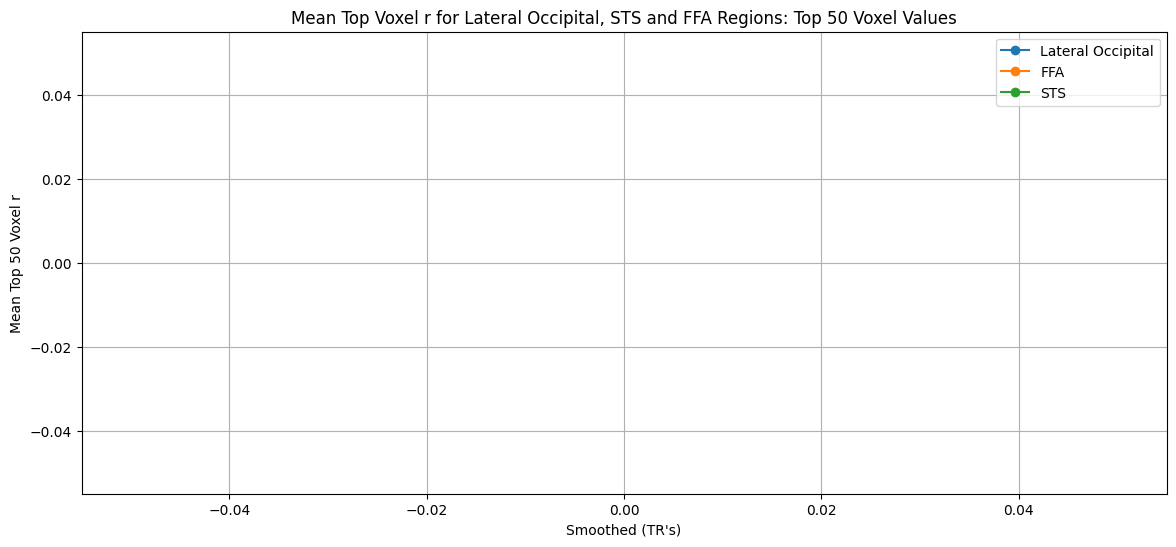

In [14]:
## aggregate trials
base_path = r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results"
regions = [ "sts","ffa","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=50
results = agg_trials(base_path, regions, n_trials=30, n_top_values=n, model_name="llava_only_social")

# Access values for each region


sts_values = results['sts']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['ffa']

# Plot the results
trials = range(0, 30)
plt.figure(figsize=(14, 6))
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Smoothed (TR's)")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values")
plt.legend()
plt.grid(True)
plt.show()




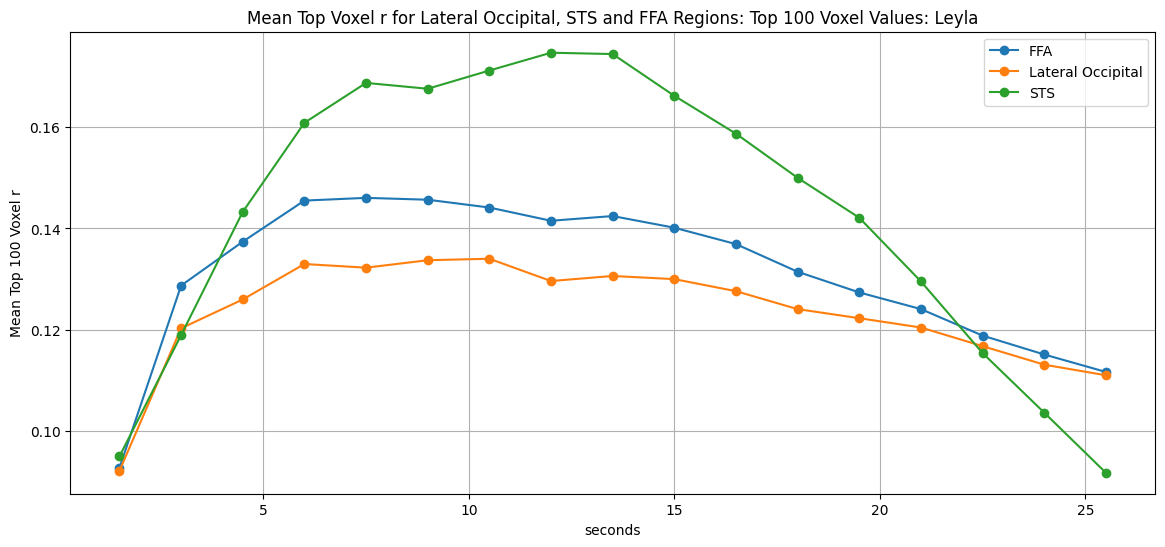

In [21]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=17, n_top_values=n, model_name="llava_1TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 18)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




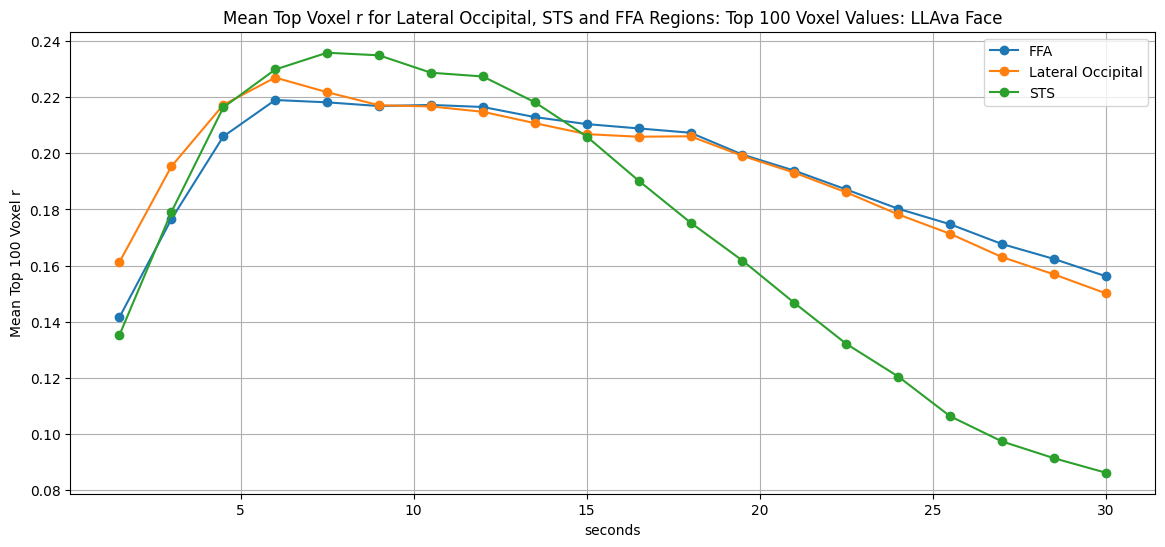

In [ ]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_only_face")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
#sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: lLAva Face")
plt.legend()
plt.grid(True)
plt.show()




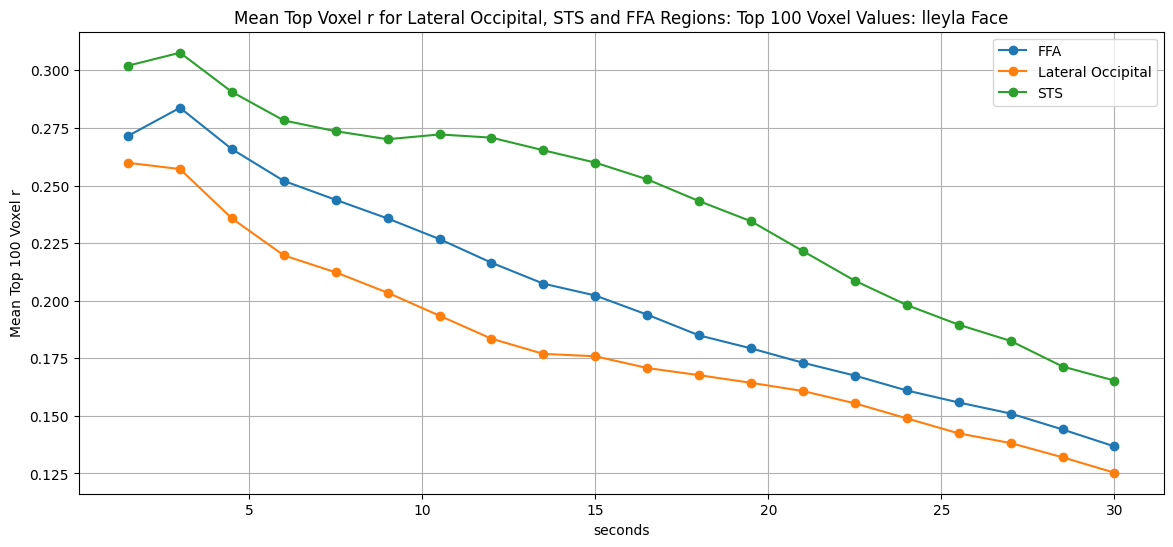

In [20]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="leyla_face")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
#sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: lleyla Face")
plt.legend()
plt.grid(True)
plt.show()



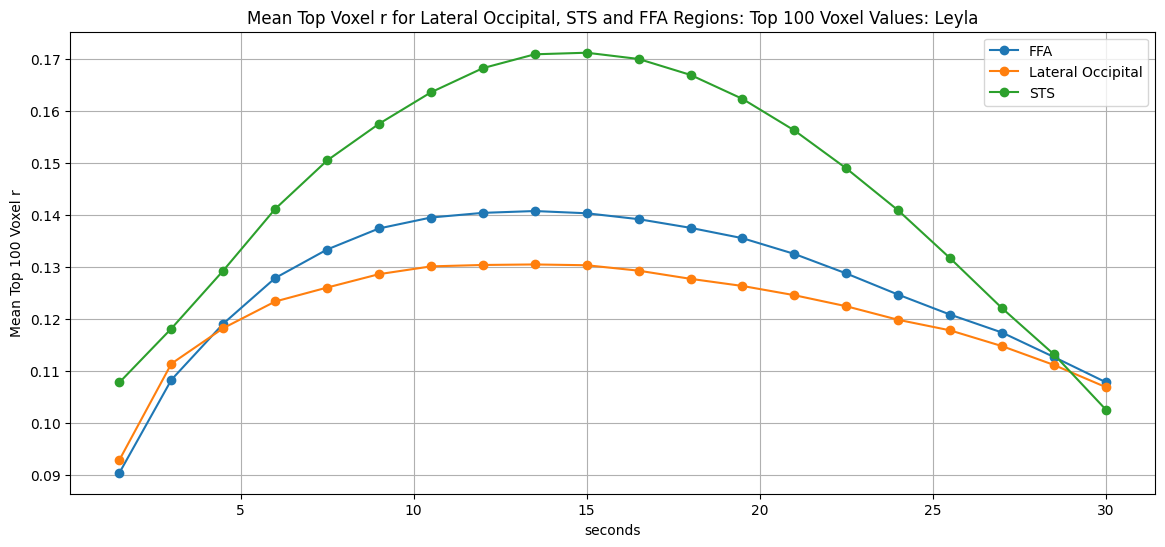

In [19]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_1TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




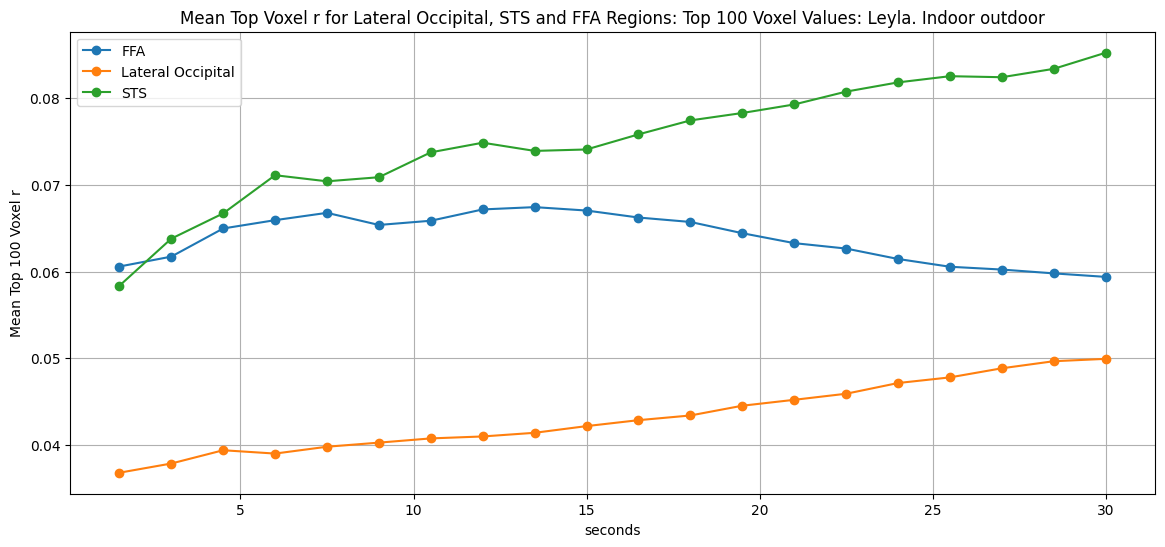

In [38]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="indoor")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla. Indoor outdoor")
plt.legend()
plt.grid(True)
plt.show()




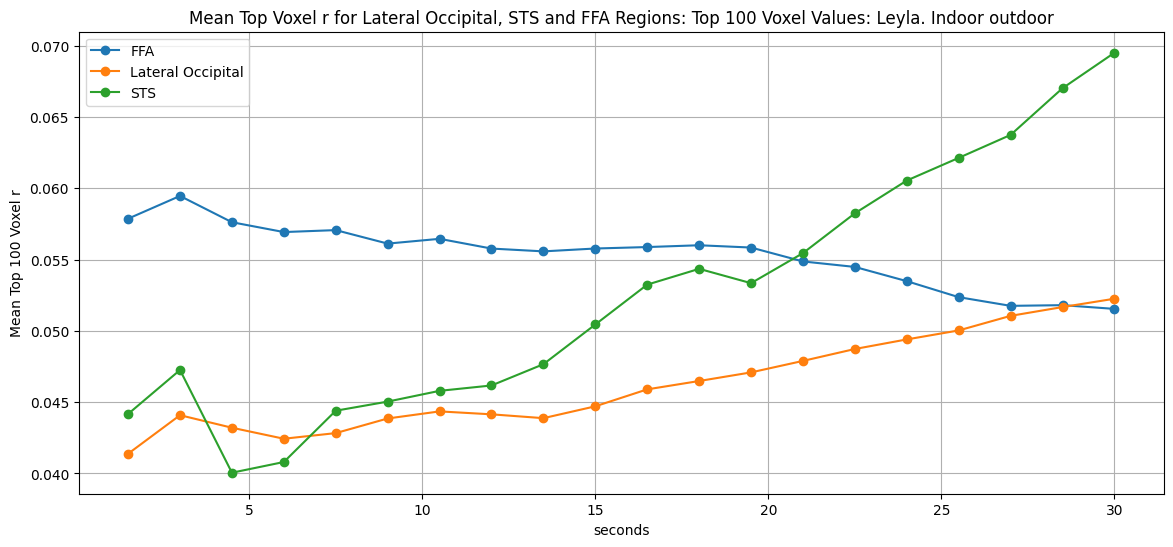

In [45]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="indoor")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 21)
trials = np.array(trials) * 1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")
#plt.plot(trials,sts_diff, label="STS - Lateral Occipital", marker="o")
plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla. Indoor outdoor")
plt.legend()
plt.grid(True)
plt.show()




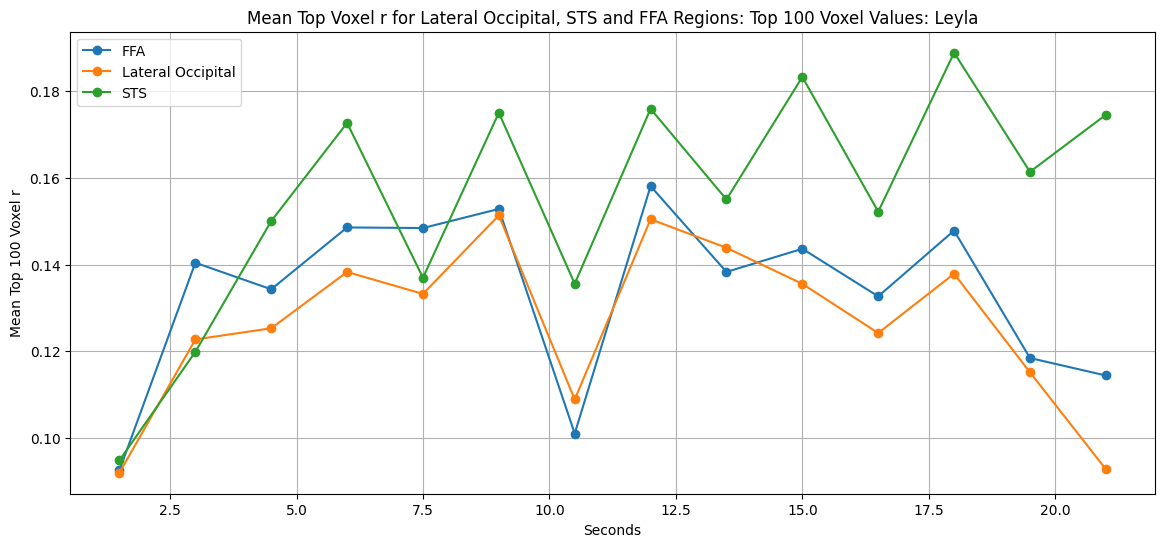

In [6]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials2(base_path, regions, n_trials=14, n_top_values=n, model_name="llava_TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 15)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




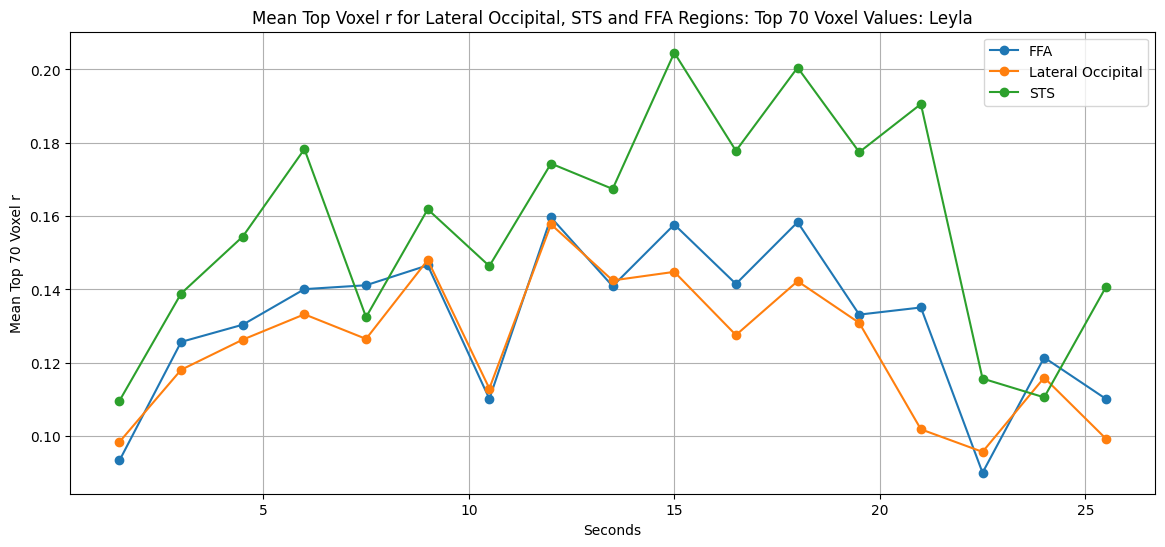

In [4]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=70
results = agg_trials2(base_path, regions, n_trials=17, n_top_values=n, model_name="llava_TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital
#sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
## smooth the sts
#sts_values = np.convolve(sts_values, np.ones(4) / 4, mode='same')
#ffa_values = np.convolve(ffa_values, np.ones(4) / 4, mode='same')
#lateral_occipital_values = np.convolve(lateral_occipital_values, np.ones(4) / 4, mode='same')
trials = range(1, 18)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




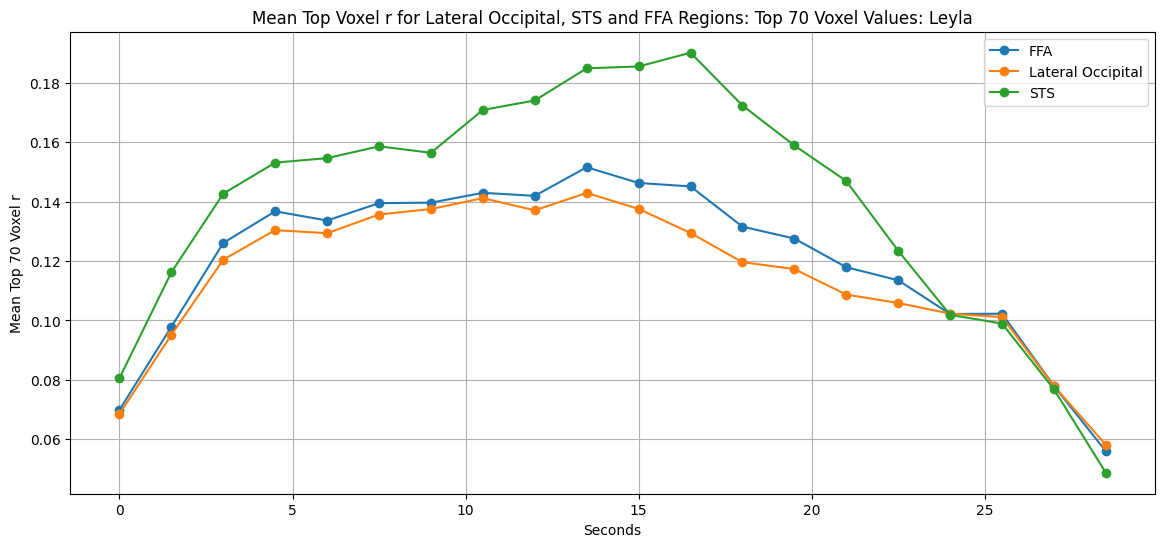

In [12]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=70
results = agg_trials2(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_TR_onlysocial")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
## smooth them
sts_values = np.convolve(sts_values, np.ones(5) / 5, mode='same')
ffa_values = np.convolve(ffa_values, np.ones(5) / 5, mode='same')
lateral_occipital_values = np.convolve(lateral_occipital_values, np.ones(5) / 5, mode='same')
# Calculate the difference between STS and Lateral Occipital
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(0, 20)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




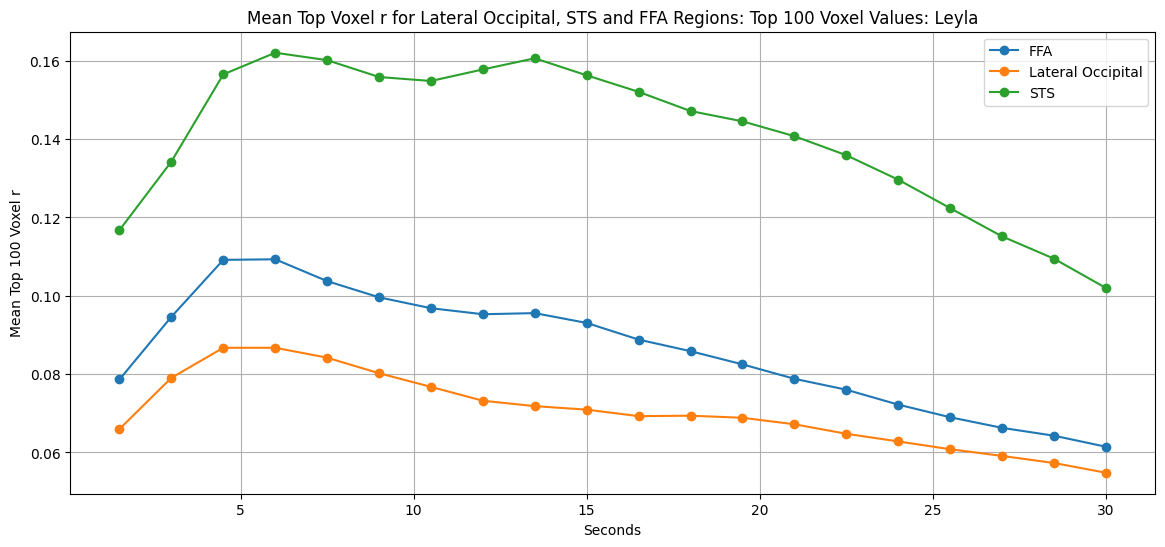

In [45]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials(base_path, regions, n_trials=20, n_top_values=n, model_name="llava_1TR_video")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital

# Plot the results
trials = range(1, 21)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




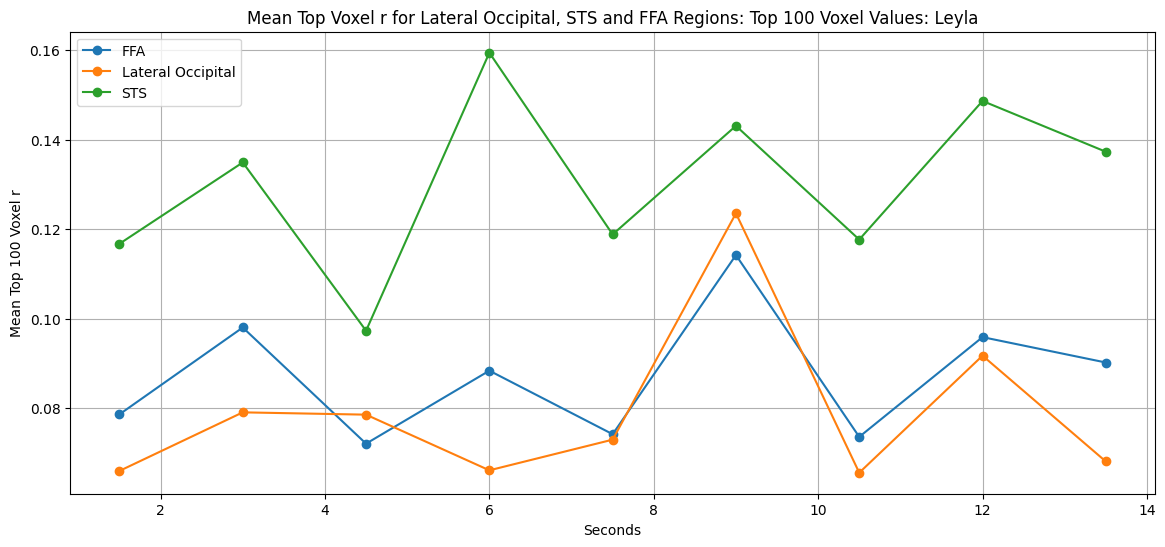

In [49]:
## aggregate trials
base_path = r"/home/new_storage/sherlock/STS_sherlock/projects data/results"
regions = [ "STS","FFA","lateral_occipital"]
#"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\results\exp_lateral_occipital_social_range\group\llava_only_social\trial_1\llava_only_social_r.nii"

# Process all regions
n=100
results = agg_trials2(base_path, regions, n_trials=9, n_top_values=n, model_name="llava_TR_video")

# Access values for each region


sts_values = results['STS']
lateral_occipital_values = results['lateral_occipital']
ffa_values = results['FFA']
# Calculate the difference between STS and Lateral Occipital
sts_diff = np.array(sts_values) - np.array(lateral_occipital_values)
# Plot the results
trials = range(1, 10)
trials = np.array(trials)  *1.5
plt.figure(figsize=(14, 6))
#plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, ffa_values, label="FFA", marker="o")

plt.plot(trials, lateral_occipital_values, label="Lateral Occipital", marker="o")
plt.plot(trials, sts_values, label="STS", marker="o")
plt.xlabel("Seconds")
plt.ylabel(f"Mean Top {n} Voxel r")
plt.title(f"Mean Top Voxel r for Lateral Occipital, STS and FFA Regions: Top {n} Voxel Values: Leyla")
plt.legend()
plt.grid(True)
plt.show()




In [19]:
def apply_mask(data, mask):
    if mask is not None:
        #mask_data = nib.load(mask).get_fdata()
        #new_mask = mask_data > 0.25
        # get the indices of the mask
        mask_indices = np.where(mask)
        new_data = data[mask_indices]
        return new_data, mask_indices
    else:
        mask_indices = np.where(np.ones(data.shape[:3])) 
        new_data = data[mask_indices]  
        return new_data, mask_indices


In [5]:
annot = np.load(r'C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\social_nonsocial.npy')

In [6]:
annot.shape

In [26]:
fmri_sts,id = apply_mask(fmri,sts_mask)
fmri_ffa,id = apply_mask(fmri,ffa_maks)

## not that the data is masked, let's take only the events where there was social interaction fmri has dims (x,t)
id = np.where(annot==1)
fmri_sts = fmri_sts[:,id[0]]
fmri_ffa = fmri_ffa[:,id[0]]

In [27]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
# Define TR (Repetition Time in seconds)
TR = 1.5  # Given TR value
fs = 1 / TR  # Sampling frequency (Hz)

# Average across voxels (time series shape is now (time_points,))
fmri_sts = np.mean(fmri_sts, axis=0)  # (time_points,)
#fmri_sts = fmri_sts.flatten()
# Compute PSD using Welch's method
freqs, psd = signal.welch(fmri_sts, fs=fs, nperseg=512)  # No need for axis argument

# Plot the averaged PSD
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd, label="Mean PSD Across Voxels", color='b')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Mean PSD of fMRI Signals (STS Masked Voxels)')
plt.legend()
plt.show()
# Define TR (Repetition Time in seconds)
TR = 1.5  # Given TR value
fs = 1 / TR  # Sampling frequency (Hz)

# Average across voxels (time series shape is now (time_points,))
fmri_ffa = np.mean(fmri_ffa, axis=0)  # (time_points,)
#fmri_ffa = fmri_ffa.flatten()

# Compute PSD using Welch's method
freqs, psd = signal.welch(fmri_ffa, fs=fs, nperseg=512)  # No need for axis argument

# Plot the averaged PSD
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd, label="Mean PSD Across Voxels", color='b')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Mean PSD of fMRI Signals (FFA Masked Voxels)')
plt.legend()
plt.show()

In [253]:
# Define TR (Repetition Time in seconds)
TR = 1.5  
fs = 1 / TR  # Sampling frequency (Hz)

# Define frequency range of interest (e.g., 0.01 Hz to 0.3 Hz for slow fMRI fluctuations)
freqs_of_interest = np.linspace(0.01, 0.15, 30)  # Define 30 frequency points in this range

# Convert frequencies to wavelet scales
# Morlet wavelet central frequency factor is ~6
scales = fs / (2 * freqs_of_interest)

# Compute Morlet Wavelet Transform
cwt_sts_matrix = signal.cwt(fmri_sts, signal.morlet2, scales, w=6)  # w=6 gives good time-frequency resolution

# Plot the time-frequency representation
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_matrix), aspect='auto', extent=[0, fmri_sts.shape[0] * TR, freqs_of_interest[0], freqs_of_interest[-1]], cmap='jet', origin='lower')

plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Morlet Wavelet Transform of fMRI Signal STS')
plt.show()

In [254]:
# Define TR (Repetition Time in seconds)
TR = 1.5  
fs = 1 / TR  # Sampling frequency (Hz)

# Define frequency range of interest (e.g., 0.01 Hz to 0.3 Hz for slow fMRI fluctuations)
freqs_of_interest = np.linspace(0.01, 0.15, 30)  # Define 30 frequency points in this range

# Convert frequencies to wavelet scales
# Morlet wavelet central frequency factor is ~6
scales = fs / (2 * freqs_of_interest)

# Compute Morlet Wavelet Transform
cwt_ffa_matrix = signal.cwt(fmri_ffa, signal.morlet2, scales, w=6)  # w=6 gives good time-frequency resolution

# Plot the time-frequency representation
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_matrix), aspect='auto', extent=[0, fmri_sts.shape[0] * TR, freqs_of_interest[0], freqs_of_interest[-1]], cmap='jet', origin='lower')

plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Morlet Wavelet Transform of fMRI Signal FFA')
plt.show()

In [262]:
cwt_ffa_matrix = cwt_ffa_matrix[:15,:]
cwt_sts_matrix = cwt_sts_matrix[:15,:]

y= np.mean(cwt_sts_matrix,axis=1)
x= np.mean(cwt_ffa_matrix,axis=1)
print(y-x)


In [9]:
fmri = image.load_img(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\fmri_data\C4\sub21\derivatives\sub-21_task-citizenfour_bold_blur_no_censor_ica.nii.gz")

In [16]:
# Get header info
header = fmri.header
data = fmri.get_fdata()
# Print key metadata
print("Shape:", fmri.shape)
print("TR (Repetition Time):", header.get_zooms()[3], "seconds")
print("Voxel dimensions:", header.get_zooms()[:3])
print("Datatype:", header.get_data_dtype())
print(fmri.shape, np.nanmax(fmri), np.nanmin(fmri))

In [17]:
print(np.nanmax(data), np.nanmin(data), np.mean(data), np.std(data))

In [3]:
ann=np.load(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\annotation_c4.npy")

In [4]:
ann.shape

In [11]:
## add a dim
ann = ann.reshape(-1,1)

In [14]:
np.save(r"C:\uni\Msc Brain\Lab work\STS_sherlock\projects data\annotations\annotation_c4.npy",ann)